# Qubit Control

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import qctrlvisualizer as qv
import qutip as qt


class Waveform:
    """A class to represent a waveform."""

    def __init__(
        self,
        dt: float,
        _values: npt.NDArray[np.complex128],
    ):
        self.dt = dt
        self._values = _values

    @property
    def values(self) -> npt.NDArray[np.complex128]:
        """Return the values array with the initial and final values included."""
        v = self._values.tolist()
        values = [v[0]] + v + [v[-1]]
        values = np.array(values, dtype=np.complex128)
        return values

    @property
    def times(self) -> npt.NDArray[np.float64]:
        """Return the times array with the initial and final times included."""
        dt = self.dt
        N = len(self._values)
        T = N * dt
        t = np.linspace(dt / 2, T - dt / 2, N).tolist()
        times = [0] + t + [T]
        times = np.array(times, dtype=np.float64)
        return times

    @property
    def duration(self) -> float:
        """Return the duration of the waveform."""
        return len(self._values) * self.dt

    def repeated(self, n: int) -> "Waveform":
        """Return a new waveform with the values repeated n times."""
        return Waveform(
            self.dt,
            np.tile(self._values, n),
        )


class Simulator:
    """A class to simulate a qubit driven by a waveform."""

    def __init__(
        self,
        dimension: int = 2,
        sampling_period: float = 1.0,
        anharmonicity: float = 0.0,
        detuning: float = 0.0,
    ):
        self.dimension = dimension
        self.sampling_period = sampling_period
        self.anharmonicity = anharmonicity
        self.detuning = detuning

    def simulate(self, waveform: Waveform):
        times = waveform.times
        iq = waveform.values
        omega = 2 * np.pi * self.detuning
        alpha = 2 * np.pi * self.anharmonicity
        a = qt.destroy(self.dimension)
        ad = a.dag()
        H_sys = []
        H_sys.append(omega * ad * a)
        H_sys.append(0.5 * alpha * ad * ad * a * a)
        H_ctrl = []
        H_ctrl.append([0.5 * ad, iq])
        H_ctrl.append([0.5 * a, np.conj(iq)])
        H = H_sys + H_ctrl
        psi0 = qt.basis(self.dimension, 0)
        result = qt.sesolve(H, psi0, times)
        return result

    def plot_waveform(self, waveform: Waveform):
        times = waveform.times
        values = waveform.values
        duration = waveform.duration
        plt.plot(times, values.real, label="I", color="C0")
        plt.plot(times, values.imag, label="Q", color="C1")
        plt.grid(color="gray", linestyle="--", alpha=0.2)
        plt.xlim(0, duration)
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
        plt.legend()

    def display_bloch_sphere(self, result):
        states = np.array(result.states).squeeze()
        qv.display_bloch_sphere(states[:, :2])

    def plot_populations(self, result):
        states = np.array(result.states).squeeze()
        populations = np.abs(states) ** 2
        qv.plot_population_dynamics(
            sample_times=result.times,
            populations={
                rf"$|{k}\rangle$": populations[:, k] for k in range(self.dimension)
            },
        )

    def print_final_populations(self, result):
        states = np.array(result.states).squeeze()
        populations = np.abs(states[-1]) ** 2
        for k in range(self.dimension):
            print(f"|{k}> : {populations[k]:>6.2%}")

    def rect_pulse(
        self,
        duration: float,
        rabi: float,
    ) -> Waveform:
        T = duration
        dt = self.sampling_period
        N = int(T / dt)
        times = np.linspace(dt / 2, T - dt / 2, N)
        values = rabi * np.ones_like(times, dtype=np.complex128)
        return Waveform(dt, values)

    def gaussian_pulse(
        self,
        duration: float,
        rabi: float,
    ) -> Waveform:
        T = duration
        dt = self.sampling_period
        N = int(T / dt)
        times = np.linspace(dt / 2, T - dt / 2, N)
        sigma = T / 6
        mu = T / 2
        real = np.exp(-((times - mu) ** 2) / (2 * sigma**2))
        area = np.sum(real) * dt
        real = real / area * rabi
        values = np.array(real, dtype=np.complex128)
        return Waveform(dt, values)

    def drag_pulse(
        self,
        duration: float,
        rabi: float,
        factor: float,
    ) -> Waveform:
        T = duration
        dt = self.sampling_period
        N = int(T / dt)
        times = np.linspace(dt / 2, T - dt / 2, N)
        sigma = T / 6
        mu = T / 2
        real = np.exp(-((times - mu) ** 2) / (2 * sigma**2))
        area = np.sum(real) * dt
        real = real / area * rabi
        alpha = 2 * np.pi * self.anharmonicity
        beta = -factor / alpha
        imag = beta * (mu - times) / sigma**2 * real
        values = real + 1j * imag
        return Waveform(dt, values)

## Gaussian Pulse

### dim = 2

In [2]:
simulator = Simulator(
    sampling_period=0.1,
    dimension=2,
    anharmonicity=-0.33,
    detuning=0.0,
)

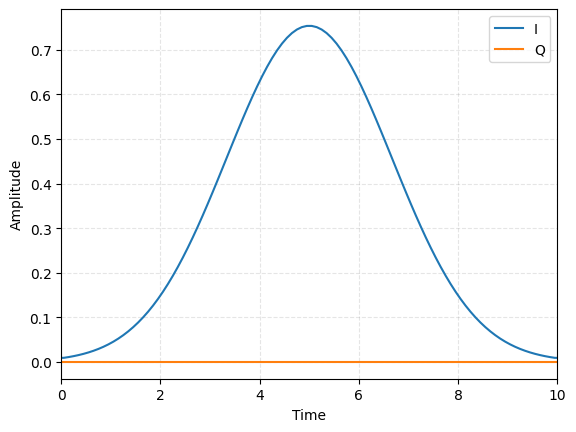

In [3]:
waveform = simulator.gaussian_pulse(
    duration=10,
    rabi=np.pi,
)

simulator.plot_waveform(waveform)

<IPython.core.display.Javascript object>

|0> :  0.00%
|1> : 100.00%


Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[-1.37500925e-06+0.j]
 [ 0.00000000e+00-1.j]]

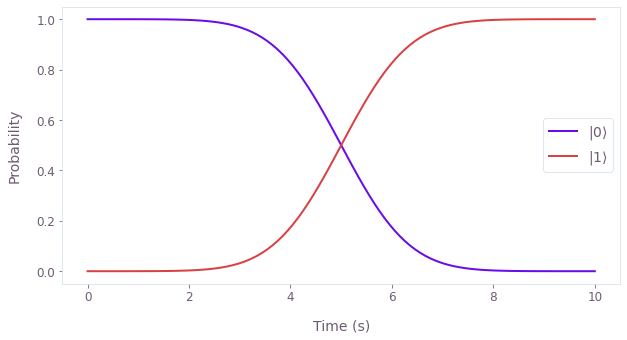

In [4]:
result = simulator.simulate(waveform)
simulator.display_bloch_sphere(result)
simulator.plot_populations(result)
simulator.print_final_populations(result)

final_state = result.states[-1]
display(final_state)

### dim = 3

In [5]:
simulator = Simulator(
    sampling_period=0.1,
    dimension=3,
    anharmonicity=-0.33,
    detuning=0.0,
)

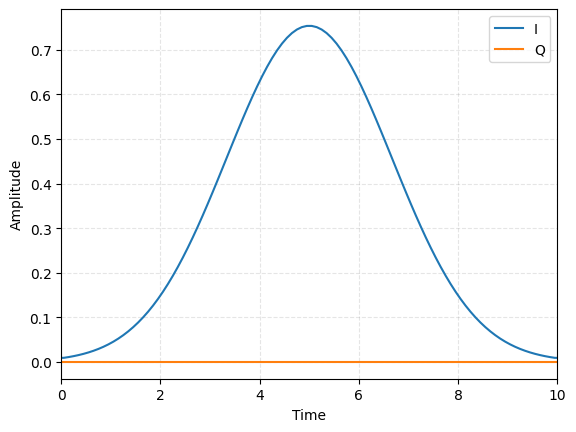

In [6]:
waveform = simulator.gaussian_pulse(
    duration=10,
    rabi=np.pi,
)

simulator.plot_waveform(waveform)

<IPython.core.display.Javascript object>

|0> :  2.30%
|1> : 97.67%
|2> :  0.02%


Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[ 0.04990592+0.14338226j]
 [-0.20348133-0.96713031j]
 [ 0.01382343-0.00376227j]]

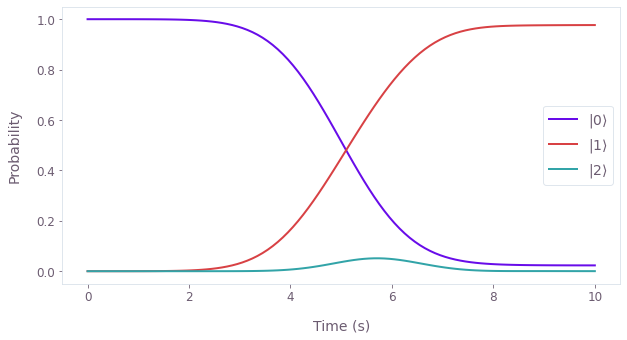

In [7]:
result = simulator.simulate(waveform)
simulator.display_bloch_sphere(result)
simulator.plot_populations(result)
simulator.print_final_populations(result)

final_state = result.states[-1]
display(final_state)

## DRAG Pulse

In [8]:
simulator = Simulator(
    sampling_period=0.1,
    dimension=3,
    anharmonicity=-0.33,
    detuning=0.0,
)

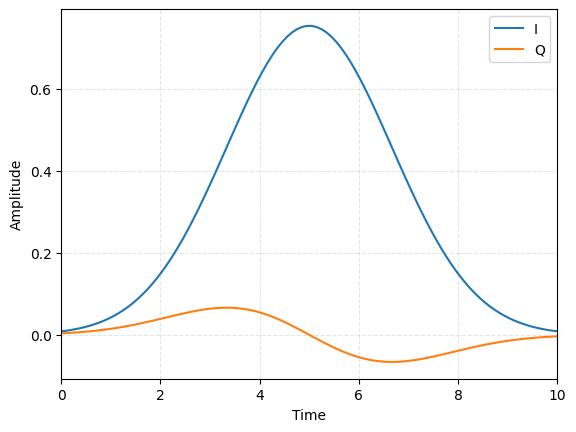

In [9]:
waveform = simulator.drag_pulse(
    duration=10,
    rabi=np.pi,
    factor=0.5,
)
simulator.plot_waveform(waveform)

<IPython.core.display.Javascript object>

|0> :  0.02%
|1> : 99.97%
|2> :  0.00%


Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[ 0.0141574 -0.0053971j ]
 [-0.19886915-0.97988958j]
 [ 0.00520796-0.00328539j]]

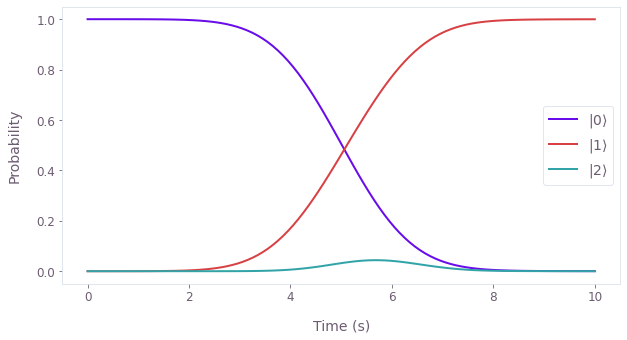

In [10]:
result = simulator.simulate(waveform)
simulator.display_bloch_sphere(result)
simulator.plot_populations(result)
simulator.print_final_populations(result)

final_state = result.states[-1]
display(final_state)